In [1]:
import torch
from torch import nn
from pathlib import Path
import numpy as np
import seaborn as sns
import scipy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# plt.style.use('dark_background')

from modules import ELBO, direct_estimation
from utils import load_sim_data

import os
import matlab.engine

### Setup parameters

In [2]:
N = 5
sim_curvature = 20 # simulated average curvature (in degrees)
n_trials = 1000
n_traj = 100

# whether to load stored data or simulate data by calling the simulation_py.mat function directly
load_from_matlab = True

In [3]:
data_path = '/Users/nguyentiendung/GitHub/perceptual-straightening/data/simulations/'
sim_path = '/Users/nguyentiendung/GitHub/perceptual-straightening/simulations/'
out_dict = '/Users/nguyentiendung/GitHub/perceptual-straightening/model/'

### Run direct estimation algorithm (Maximum Likelihood) to initialize posterior probabilities

In [4]:
c_est, c_true, c, d, a, ExpParam, Data, Pc_reshaped = direct_estimation(sim_path, n_traj=n_traj, n_frames=N, n_dim=N-1, n_iterations=1000, n_trials=n_trials, sim_curvature=sim_curvature)

Proportion of correct responses: 0.6817600131034851
Trajectory: 0
Trajectory: 1
Trajectory: 2
Trajectory: 3
Trajectory: 4
Trajectory: 5
Trajectory: 6
Trajectory: 7
Trajectory: 8
Trajectory: 9
Trajectory: 10
Trajectory: 11
Trajectory: 12
Trajectory: 13
Trajectory: 14
Trajectory: 15
Trajectory: 16
Trajectory: 17
Trajectory: 18
Trajectory: 19
Trajectory: 20
Trajectory: 21
Trajectory: 22
Trajectory: 23
Trajectory: 24
Trajectory: 25
Trajectory: 26
Trajectory: 27
Trajectory: 28
Trajectory: 29
Trajectory: 30
Trajectory: 31
Trajectory: 32
Trajectory: 33
Trajectory: 34
Trajectory: 35
Trajectory: 36
Trajectory: 37
Trajectory: 38
Trajectory: 39
Trajectory: 40
Trajectory: 41
Trajectory: 42
Trajectory: 43
Trajectory: 44
Trajectory: 45
Trajectory: 46
Trajectory: 47
Trajectory: 48
Trajectory: 49
Trajectory: 50
Trajectory: 51
Trajectory: 52
Trajectory: 53
Trajectory: 54
Trajectory: 55
Trajectory: 56
Trajectory: 57
Trajectory: 58
Trajectory: 59
Trajectory: 60
Trajectory: 61
Trajectory: 62
Trajectory: 6

/opt/anaconda3/envs/vision/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


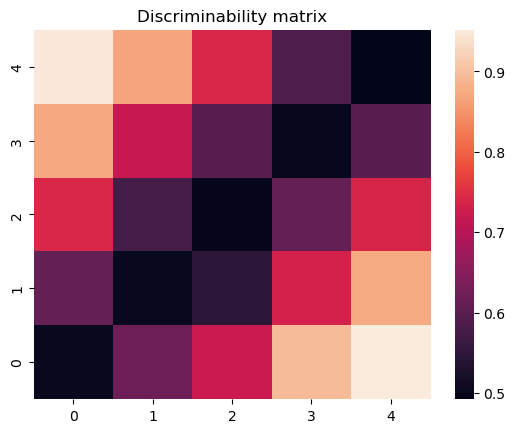

In [5]:
# plot discriminability matrix
ax = sns.heatmap(Pc_reshaped)
ax.invert_yaxis()
ax.set_title('Discriminability matrix')
plt.show()

In [6]:
## # create initial values
# d_post_init = d.squeeze() + torch.randn(d.squeeze().size())
# d_post_init = d.squeeze()

# c_post_init = torch.zeros(N-1)
# c_post_init[1:] = c.squeeze() 
# c_post_init[0] = torch.mean(c)
# c_post_init += torch.randn(c_post_init.size()) * 0.1
# c_post_init = torch.zeros(1, N-1)
# c_post_init[:, 1:] = c 
# c_post_init[:, 0] = torch.mean(c)
# c_post_init += torch.randn(c_post_init.size()) * 0.1
# U, S, _ = torch.linalg.svd(torch.cov(c_post_init.t() @ c_post_init))
# c_post_init = U @ torch.diag(torch.sqrt(S))[0,:].squeeze()
# c_post_init = c.squeeze() 
# c_post_init += torch.randn(c_post_init.size()) * 0.1

# a_post_init = torch.zeros(N-1, N-1)
# a_post_init[1:] = a.squeeze()
# a_post_init[0] = torch.mean(a.squeeze(), dim=0)

In [7]:
# # diagonal initialization
# U, S, Vh = torch.linalg.svd(torch.hstack((d, c, torch.reshape(a, (a.shape[0], -1,)))).T, full_matrices=False)
# d_init = Vh[:4, :].T
# c_init = Vh[4:7, :].T
# a_init = torch.reshape(Vh[7:, :].T, (-1, a.shape[1], a.shape[2]))

In [8]:
# # create initial values
# mu_prior_d_init = torch.mean(d_init.detach()).view(1)
# mu_prior_c_init = torch.mean(c_init.detach()).view(1)
# mu_prior_a_init = torch.zeros(N-1, requires_grad=False)
# mu_prior_l_init = torch.tensor([0.0], requires_grad=False)

# sigma_prior_d_init = torch.var(d_init.detach()).view(1)
# sigma_prior_c_init = torch.var(c_init.detach()).view(1)
# sigma_prior_a_init = torch.var(a_init.detach(), [0, 1])
# sigma_prior_l_init = torch.tensor([1.0], requires_grad=False)

# mu_post_d_init = torch.randn(N-1)
# mu_post_c_init = torch.randn(N-1) * torch.pi
# mu_post_a_init = torch.zeros(N-1, N-1, requires_grad=False)
# mu_post_l_init = torch.zeros(N-1, requires_grad=False)
# sigma_post_init = torch.randn(N-1, 3 + (N-1), 3 + (N-1))

In [9]:
# create initial values
mu_post_d_init = torch.mean(d.detach(), 0)
mu_post_c_init = torch.mean(c.detach(), 0)
mu_post_a_init = torch.mean(a.detach(), 0)
mu_post_l_init = torch.tensor([0.0])
M = torch.numel(mu_post_d_init) + torch.numel(mu_post_c_init) + torch.numel(mu_post_a_init) + torch.numel(mu_post_l_init)

sigma_post_init = torch.randn(M, M)

mu_prior_d_init = torch.mean(mu_post_d_init)
# mu_prior_c_init = torch.mean(mu_post_c_init)
mu_prior_c_init = torch.deg2rad(torch.tensor(20))
mu_prior_a_init = torch.zeros(N-1, requires_grad=False) # maybe change that to be the mean of the posterior
mu_prior_l_init = torch.tensor([0.0], requires_grad=False)

d_size = N - 1
c_size = N - 2
a_size = (N - 1) * (N - 2)
sigma_prior_d_init = torch.var(mu_post_d_init, correction=False, keepdim=True) + torch.exp(0.5 * torch.mean(torch.diag(sigma_post_init)[:d_size]))
sigma_prior_c_init = torch.var(mu_post_c_init, correction=False, keepdim=True) + torch.exp(0.5 * torch.mean(torch.diag(sigma_post_init)[d_size:d_size + c_size]))
sigma_prior_a_init = torch.var(mu_post_a_init, dim=0, correction=False) + torch.exp(0.5 * torch.mean(torch.diag(sigma_post_init)[d_size + c_size:d_size + c_size + a_size]))
sigma_prior_l_init = torch.tensor([1.0], requires_grad=False)

### Run inference

In [10]:
eps = 1e-6
sim_traj = 1 # number of trajectories to simulate (recovery analysis)
# model = ELBO(N, d_post_init, c_post_init, eps=eps)
model = ELBO(N, 
             mu_prior_d_init, 
             mu_prior_c_init, 
             mu_prior_a_init, 
             mu_prior_l_init, 
             sigma_prior_d_init,
             sigma_prior_c_init,
             sigma_prior_a_init,
             sigma_prior_l_init,
             mu_post_d_init,
             mu_post_c_init,
             mu_post_a_init,
             mu_post_l_init,
             sigma_post_init,
             eps=eps)

lr = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# model_file = Path(out_dict) / f'model_{sim_curvature}.pt'

#### Load behavioral data

In [11]:
 # load trial information
if load_from_matlab:
    os.chdir(sim_path)

    # # start MATLAB engine
    # eng = matlab.engine.start_matlab()
    # ExpParam, Data, Pc_reshaped = eng.simulation_py(sim_curvature, N, N-1, n_trials, nargout=3)

    # # stop MATLAB engine
    # eng.quit()

    # extract data matrices
    trial_mat = torch.tensor(Data['resp_mat'])
    pair_inds = torch.tensor(ExpParam['all_pairs'])
    print('Successfully loaded data from MATLAB script.') # data was generated in the direct_estimation() function

else:
    trial_mat = torch.from_numpy(scipy.io.loadmat(Path(data_path) / 'Data.mat')['Data']['resp_mat'][0][0]) 
    pair_inds = torch.from_numpy(scipy.io.loadmat(Path(data_path) / 'ExpParam.mat')['ExpParam']['all_pairs'][0][0]) 
    print('Successfully loaded stored data.')

Successfully loaded data from MATLAB script.


#### Optimize the whole ELBO

In [12]:
iterations = 20000

# errors
errors = np.zeros(iterations)
kl_loss = np.zeros(iterations)
ll_loss = np.zeros(iterations)

# variables
c_prior = np.zeros(iterations)
d_prior = np.zeros(iterations)
# c_post = np.zeros((N-1, iterations))
c_post = np.zeros((N-2, iterations))

best_iteration = 0
for i in range(iterations):
    
    # clear gradients
    optimizer.zero_grad()

    log_ll, d, c, a = model.compute_likelihood(trial_mat, pair_inds, n_samples=1000)
    kl = model.kl_divergence()
    loss = model.compute_loss(log_ll, kl)

    # gradient update
    loss.backward()
    optimizer.step()

    # store errors for each iteration
    errors[i] = loss.item()
    kl_loss[i] = kl.item()
    ll_loss[i] = log_ll.item()
    c_prior[i] = np.rad2deg(model.mu_prior_c.detach().numpy())
    d_prior[i] = model.mu_prior_d.detach().numpy()
    c_post[:, i] = np.rad2deg(model.mu_post_c.detach().numpy())

    # print progress
    if not i % 250:
        print(f"Epoch: {i}, Loss: {loss.item()}")

# # save parameters
# phi_params = {'d': d_best,
#               'c': c_best,
#               'a': a_best}
# torch.save(phi_params, Path(data_path) / f'params_{sim_curvature}.pt')
# torch.save(model.state_dict(), model_file)

Epoch: 0, Loss: 1371.343994140625
Epoch: 250, Loss: 399.1653137207031
Epoch: 500, Loss: 181.3262939453125
Epoch: 750, Loss: 119.65885925292969
Epoch: 1000, Loss: 101.96553039550781
Epoch: 1250, Loss: 92.19039916992188
Epoch: 1500, Loss: 88.0128402709961
Epoch: 1750, Loss: 83.7215576171875
Epoch: 2000, Loss: 81.00732421875
Epoch: 2250, Loss: 76.51840209960938
Epoch: 2500, Loss: 71.82394409179688
Epoch: 2750, Loss: 66.95906829833984
Epoch: 3000, Loss: 61.76293182373047
Epoch: 3250, Loss: 59.052650451660156
Epoch: 3500, Loss: 55.75121307373047
Epoch: 3750, Loss: 50.84727096557617
Epoch: 4000, Loss: 46.25921630859375
Epoch: 4250, Loss: 41.3272590637207
Epoch: 4500, Loss: 36.33348083496094
Epoch: 4750, Loss: 33.19886779785156
Epoch: 5000, Loss: 31.677215576171875
Epoch: 5250, Loss: 30.85948944091797
Epoch: 5500, Loss: 30.298137664794922
Epoch: 5750, Loss: 29.929738998413086
Epoch: 6000, Loss: 29.336353302001953
Epoch: 6250, Loss: 28.820554733276367
Epoch: 6500, Loss: 28.534603118896484
Epoc

In [13]:
# for name, param in model.named_parameters():
#     print(f"{name}: is_leaf={param.is_leaf}, requires_grad={param.requires_grad}")

#### Load final model and plot error curves

In [14]:
# best_model = ELBO(N, data_path, eps)
# best_model.load_state_dict(torch.load(model_file, weights_only=True))

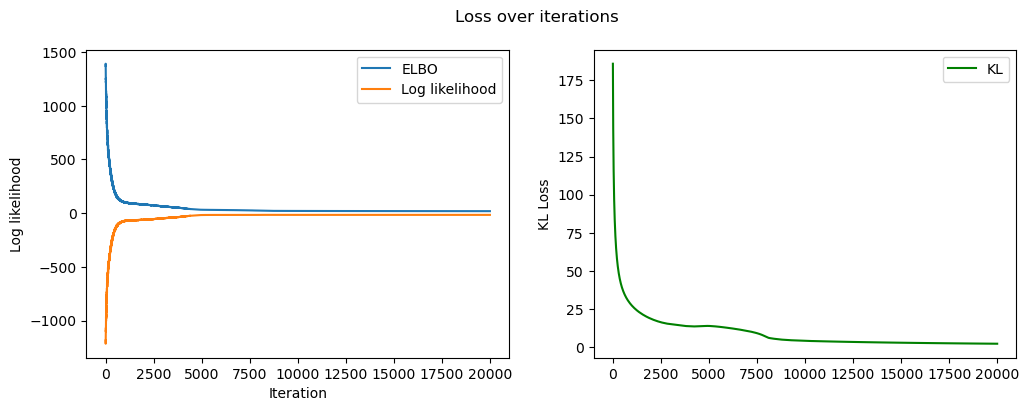

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Primary y-axis (ELBO and Neg. log likelihood)
axs[0].plot(errors, label='ELBO')
axs[0].plot(ll_loss, label='Log likelihood')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Log likelihood')
# axs[0].set_yscale('log')
# axs[0].tick_params(axis='y')

axs[1].plot(kl_loss, label='KL', color='green')
axs[1].set_ylabel('KL Loss')
# axs[1].tick_params(axis='y')
# axs[1].set_yscale('log')

# Add legends for both axes
axs[0].legend()
axs[1].legend()

# save and show the plot
fig.suptitle('Loss over iterations')
plt.savefig(Path(out_dict) / f"error_{sim_curvature}")
plt.show()

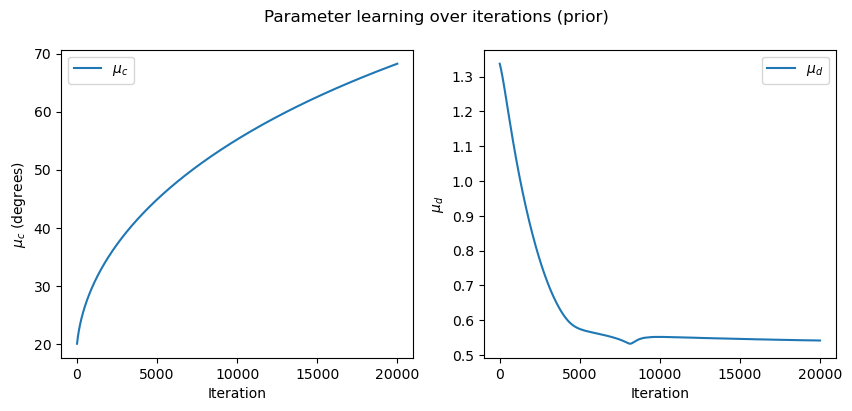

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(c_prior, label=r'$\mu_c$')
axs[0].set_ylabel(r'$\mu_{c}$ (degrees)')

axs[1].plot(d_prior, label=r'$\mu_d$')
axs[1].set_ylabel(r'$\mu_{d}$')

for i in range(2):
    axs[i].legend()
    axs[i].set_xlabel('Iteration')

fig.suptitle('Parameter learning over iterations (prior)')
plt.show()

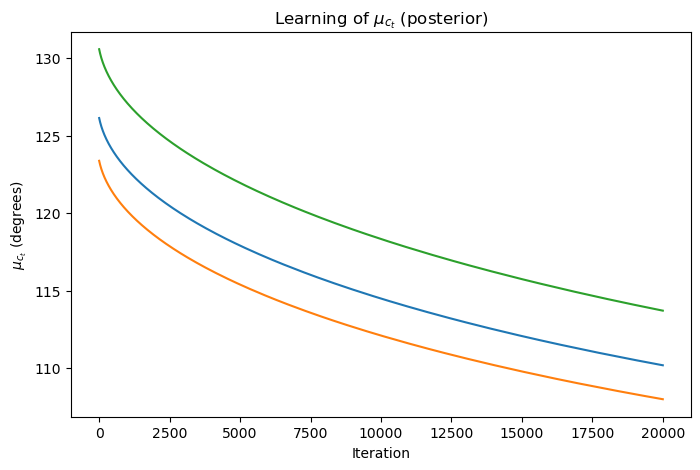

In [17]:
plt.figure(figsize=(8, 5))
for i in range(N-2):
# for i in range(N-1):
    plt.plot(c_post[i, :])
plt.title(r"Learning of $\mu_{c_t}$ (posterior)")
plt.ylabel(r'$\mu_{c_t}$ (degrees)')
plt.xlabel("Iteration")
plt.show()

In [18]:
# plt.plot(c_post[6])
# plt.show()

### Reconstruct trajectory

In [19]:
# est_global_curvature = best_model.mu_c.detach().numpy() * (180 / np.pi)
est_global_curvature = np.rad2deg(model.mu_prior_c.detach().numpy())
print(f'Estimated global curvature: {est_global_curvature} degrees')
# print(f'Average estimated local curvature: {torch.mean(c_best).detach().numpy() * (180/np.pi)} degrees')
print(f'Average estimated local curvature: {np.rad2deg(torch.mean(c).detach().numpy())} degrees')

Estimated global curvature: 68.24723815917969 degrees
Average estimated local curvature: 94.82323455810547 degrees


In [20]:
def run_pca(X, n_components=2):
    """
    Run PCA on the estimated trajectory. 

    Inputs:
    -------
    X: (n_dimensions x n_frames) torch tensor
        Input matrix (estimated trajectory)
    n_components: Scalar
        Number of fitted principle components

    Output:
    -------
    X_new: (n_frames x n_components) numpy array
        Transformed values
    """
    
    pca = PCA(n_components)
    pca.fit(X)
    return pca.components_

In [21]:
# if load_from_matlab:
#     # plot data
#     ax = sns.heatmap(Pc_reshaped, cmap='Blues')
#     ax.invert_yaxis()
#     plt.show()

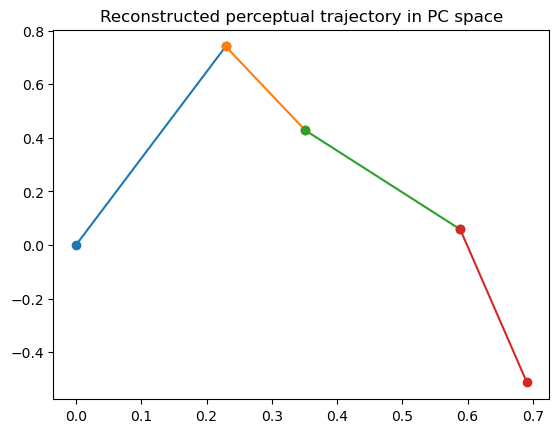

In [22]:
# run PCA to reduce the dimensionality of the trajectory
# x = torch.squeeze(best_model.construct_trajectory(torch.mean(d_best, dim=0, keepdim=True), 
#                                torch.mean(c_best, dim=0, keepdim=True), 
#                                torch.mean(a_best, dim=0, keepdim=True)))
x = torch.squeeze(model.construct_trajectory(torch.mean(d, dim=0, keepdim=True), 
                               torch.mean(c, dim=0, keepdim=True), 
                               torch.mean(a, dim=0, keepdim=True)))

pc = run_pca(x.t().detach().numpy())
for i in range(pc.shape[1]-1):
    plt.plot([pc[0, i], pc[0, i+1]], [pc[1, i], pc[1, i+1]], '-o')
plt.title('Reconstructed perceptual trajectory in PC space')
plt.show()

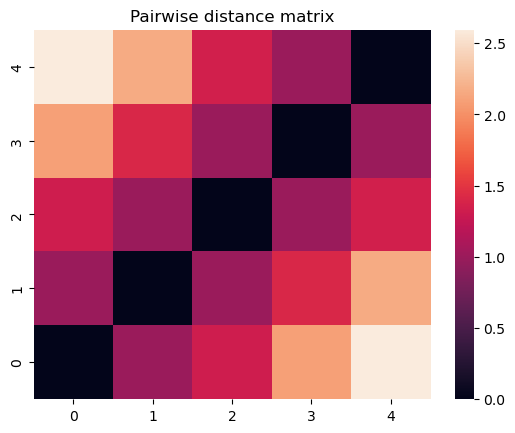

In [23]:
# compute pairwise distance matrix
pairwise_dist = torch.cdist(x, x)
ax = sns.heatmap(pairwise_dist.detach().numpy())
ax.invert_yaxis()
ax.set_title('Pairwise distance matrix')
plt.show()

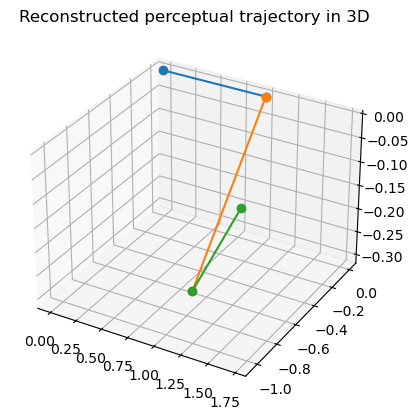

In [24]:
x_np = x.detach().numpy().T
fig = plt.figure()
if N-1 == 2:
    # visualize the perceptual trajectory for 2d 
    ax = fig.add_subplot(111)
    for i in range(x.shape[1]-1):
        plt.plot([x_np[0, i], x_np[0, i+1]], 
                 [x_np[1, i], x_np[1, i+1]],)
    plt.title('Reconstructed perceptual trajectory in 2D')
    plt.show()
elif N-1 >= 3:
    # visualize the perceptual trajectory for >= 3d (plotting first 3 dimensions)
    ax = fig.add_subplot(111, projection='3d')
    for i in range(x.shape[1]-1):
        plt.plot([x_np[0, i], x_np[0, i+1]], 
                 [x_np[1, i], x_np[1, i+1]],
                 [x_np[2, i], x_np[2, i+1]], '-o')
    plt.title('Reconstructed perceptual trajectory in 3D')
    plt.show()

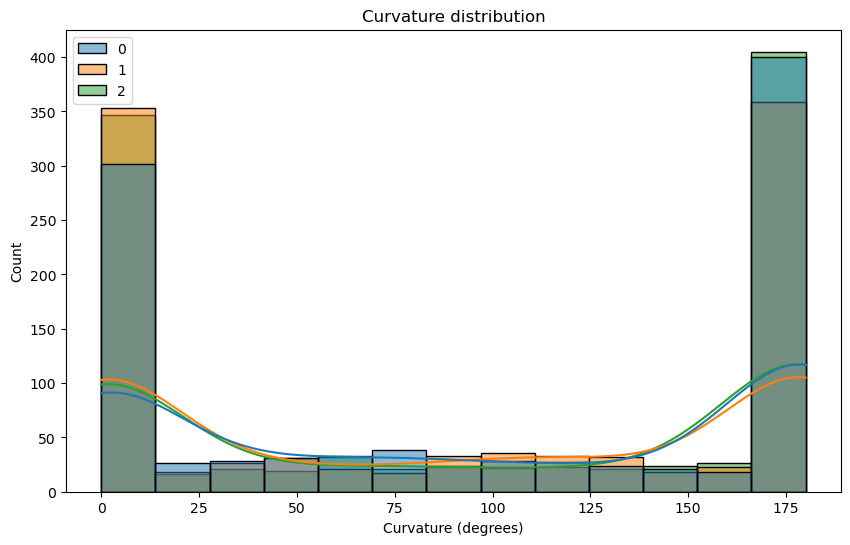

In [25]:
# plot histograms of trajectory variables
# fig, axs = plt.subplots(figsize=(10, 6))
# sns.histplot(c_best.detach().numpy() * (180 / np.pi), kde=True, ax=axs)
# axs.set_xlabel('Curvature (degrees)')
# axs.set_title('Curvature distribution')
# plt.show()
fig, axs = plt.subplots(figsize=(10, 6))
sns.histplot(np.rad2deg(c.detach().numpy()), kde=True, ax=axs)
axs.set_xlabel('Curvature (degrees)')
axs.set_title('Curvature distribution')
plt.show()